In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

from sklearn import preprocessing
from sklearn import impute
from sklearn import pipeline

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

2023-08-08 06:11:35.763949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(2112)
tf.random.set_seed(2112)

***
## loading data

In [3]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [4]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [5]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 5

10


In [6]:
alpha_labels = ["Alpha_A", "Alpha_B", "Alpha_D", "Alpha_G"]
beta_labels = ["Beta_A","Beta_B","Beta_C"]
gamma_labels = ["Gamma_A","Gamma_B","Gamma_E","Gamma_F","Gamma_G","Gamma_H","Gamma_M","Gamma_N"]
delta_labels = ["Delta_A","Delta_B","Delta_C","Delta_D"]

In [7]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [8]:
# create sample weight column
train["weight"] = 1.
idx = train.query("Class == 1").index
train.loc[idx,"weight"] = scale_pos_weight

***
## training

In [9]:
def create_model_instance(
        hidden_size=64, 
        dropout1=0.1, 
        dropout2=0.05,
        l2_lambda=1e-3,
        label_smoothing=0.01,
        activation="relu",
    ):
    input = tf.keras.Input(shape=(56,))
    x = tf.keras.layers.Dropout(dropout1)(input)
    x = tf.keras.layers.Dense(
        hidden_size, 
        activation=activation, 
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    x = tf.keras.layers.Dropout(dropout2)(x)
    output1 = Dense(
        4, 
        activation='softmax', 
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output2 = Dense(
        3,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output3 = Dense(
        8,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output4 = Dense(
        4, 
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)

    model = tf.keras.models.Model(
        inputs=input, 
        outputs=[output1, output2, output3, output4]
    )
    model.compile(
        optimizer='adam',
        loss=[
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        ],
        loss_weights=[1., 1., 1., 1.],
    )
    return model

In [10]:
def balanced_logloss_(y_pred, y_true, eps=1e-7):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2

In [11]:
def train_validate(
        dataframe,
        input_cols, 
        instance_params,
        fit_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)
            
            model = create_model_instance(**instance_params)
            model.fit(
                x = train_df[input_cols].values, 
                y = [
                    train_df[alpha_labels].values, 
                    train_df[beta_labels].values, 
                    train_df[gamma_labels].values,
                    train_df[delta_labels].values,
                ], 
                sample_weight = train_df["weight"].values,
                shuffle = True,
                verbose = 0,
                **fit_params
            )
            
            out1,_,_,_ = model.predict(valid_df[input_cols].values, verbose=0)
            y_pred = out1[:,1:].sum(axis=1)

            metrics.append( balanced_logloss_(y_pred, valid_df["Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    
    instance_params = dict(
        hidden_size = trial.suggest_int("hidden_size", 32, 512, 16),
        dropout1 = trial.suggest_float("dropout1", 0.0, 0.2),
        dropout2 = trial.suggest_float("dropout2", 0.0, 0.2),
        l2_lambda = trial.suggest_float("l2_lambda", 1e-10, 1e-1, log=True),
        label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.1),
        #activation = trial.suggest_categorical("activation", ["relu","sigmoid","tanh"]), 
    ) 
    fit_params = dict(
        epochs = trial.suggest_int("epochs", 100, 400, 10), 
        batch_size = trial.suggest_int("batch_size", 16, 256, 16),
    )
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        instance_params = instance_params,
        fit_params = fit_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [12]:
%%time

instance_params = {
    "hidden_size":100,
    "dropout1":0.05,
    "dropout2":0.05,
    "l2_lambda":1e-4,
    "label_smoothing":0.01,
    "activation":"relu",
}
fit_params = {
    "epochs":100,
    "batch_size":32,
}

train_validate(
    dataframe = train,
    input_cols = input_cols,
    instance_params = instance_params,
    fit_params = fit_params,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False,
)

CPU times: user 3min 10s, sys: 30.2 s, total: 3min 40s
Wall time: 2min 16s


(0.37699935889729747, 0.07383735091246565)

In [13]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-mlp",
    direction='minimize',
    storage='sqlite:///iarc-mlp.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=1000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-08-08 06:13:55,998] Using an existing study with name 'iarc-mlp' instead of creating a new one.


[I 2023-08-08 06:16:16,462] Trial 2 finished with value: 0.35748762273586626 and parameters: {'batch_size': 176, 'dropout1': 0.04332916684605703, 'dropout2': 0.051534816338218326, 'epochs': 200, 'hidden_size': 416, 'l2_lambda': 1.5320691382968764e-08, 'label_smoothing': 0.0168590224809539}. Best is trial 2 with value: 0.35748762273586626.


[I 2023-08-08 06:18:37,790] Trial 3 finished with value: 0.3641138459168141 and parameters: {'batch_size': 176, 'dropout1': 0.08640568209645293, 'dropout2': 0.13368242645675954, 'epochs': 220, 'hidden_size': 304, 'l2_lambda': 0.0007615900581704039, 'label_smoothing': 0.08023506178244406}. Best is trial 2 with value: 0.35748762273586626.


[I 2023-08-08 06:21:58,767] Trial 4 finished with value: 0.34887516767393056 and parameters: {'batch_size': 208, 'dropout1': 0.11861631669368906, 'dropout2': 0.09439595785226912, 'epochs': 370, 'hidden_size': 304, 'l2_lambda': 0.00020211699469531316, 'label_smoothing': 0.050402035236971926}. Best is trial 4 with value: 0.34887516767393056.


[I 2023-08-08 06:24:14,482] Trial 5 finished with value: 0.40197919167587526 and parameters: {'batch_size': 48, 'dropout1': 0.10805006425512263, 'dropout2': 0.04016171109794438, 'epochs': 130, 'hidden_size': 32, 'l2_lambda': 8.986265066655216e-10, 'label_smoothing': 0.03225279011150816}. Best is trial 4 with value: 0.34887516767393056.


[I 2023-08-08 06:27:53,144] Trial 6 finished with value: 0.3251933380030778 and parameters: {'batch_size': 128, 'dropout1': 0.06614514485948585, 'dropout2': 0.07327445482835675, 'epochs': 360, 'hidden_size': 368, 'l2_lambda': 7.223331405284845e-10, 'label_smoothing': 0.0911348779063548}. Best is trial 6 with value: 0.3251933380030778.


[I 2023-08-08 06:39:10,302] Trial 7 finished with value: 0.3339841517385607 and parameters: {'batch_size': 16, 'dropout1': 0.16324585881481912, 'dropout2': 0.016376760587666263, 'epochs': 390, 'hidden_size': 320, 'l2_lambda': 2.0466417379125694e-09, 'label_smoothing': 0.0601512904974934}. Best is trial 6 with value: 0.3251933380030778.


[I 2023-08-08 06:42:09,267] Trial 8 finished with value: 0.3428654725274912 and parameters: {'batch_size': 64, 'dropout1': 0.07597041088022481, 'dropout2': 0.10681912321063945, 'epochs': 210, 'hidden_size': 224, 'l2_lambda': 3.977815516918653e-05, 'label_smoothing': 0.03166842131299126}. Best is trial 6 with value: 0.3251933380030778.


[I 2023-08-08 06:45:00,655] Trial 9 finished with value: 0.35162117901011664 and parameters: {'batch_size': 112, 'dropout1': 0.0841278258838607, 'dropout2': 0.015397125362829556, 'epochs': 250, 'hidden_size': 272, 'l2_lambda': 1.2856903281878198e-10, 'label_smoothing': 0.025915913332076358}. Best is trial 6 with value: 0.3251933380030778.


[I 2023-08-08 06:48:03,540] Trial 10 finished with value: 0.35849475320031493 and parameters: {'batch_size': 224, 'dropout1': 0.14521793323474005, 'dropout2': 0.04963921463346069, 'epochs': 310, 'hidden_size': 432, 'l2_lambda': 8.560131327825331e-08, 'label_smoothing': 0.09484279461928458}. Best is trial 6 with value: 0.3251933380030778.


[I 2023-08-08 06:52:00,280] Trial 11 finished with value: 0.33463792183521074 and parameters: {'batch_size': 112, 'dropout1': 0.001321433595713864, 'dropout2': 0.19005945079134157, 'epochs': 320, 'hidden_size': 512, 'l2_lambda': 6.085410660463298e-07, 'label_smoothing': 0.09841979539465741}. Best is trial 6 with value: 0.3251933380030778.


[I 2023-08-08 07:03:04,178] Trial 12 finished with value: 0.3346653269984848 and parameters: {'batch_size': 16, 'dropout1': 0.19991326054797376, 'dropout2': 0.007898432589639959, 'epochs': 400, 'hidden_size': 160, 'l2_lambda': 3.8217556384657415e-09, 'label_smoothing': 0.06870266328256332}. Best is trial 6 with value: 0.3251933380030778.


[I 2023-08-08 07:06:01,979] Trial 13 finished with value: 0.35843222634689903 and parameters: {'batch_size': 256, 'dropout1': 0.15607512804813156, 'dropout2': 0.0073211695761656904, 'epochs': 350, 'hidden_size': 416, 'l2_lambda': 3.739628509500249e-10, 'label_smoothing': 0.06817429932854653}. Best is trial 6 with value: 0.3251933380030778.


[I 2023-08-08 07:10:17,271] Trial 14 finished with value: 0.3202493041284282 and parameters: {'batch_size': 80, 'dropout1': 0.04264082117010471, 'dropout2': 0.06949470347598409, 'epochs': 400, 'hidden_size': 176, 'l2_lambda': 3.856059587986953e-08, 'label_smoothing': 0.05380758019475476}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:13:40,258] Trial 15 finished with value: 0.35494963015241127 and parameters: {'batch_size': 96, 'dropout1': 0.04604874076509334, 'dropout2': 0.06753270240727212, 'epochs': 310, 'hidden_size': 128, 'l2_lambda': 1.0675498567087027e-07, 'label_smoothing': 0.005522570846925978}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:17:24,543] Trial 16 finished with value: 0.619069215941479 and parameters: {'batch_size': 80, 'dropout1': 0.04615318526254945, 'dropout2': 0.07267536964322695, 'epochs': 340, 'hidden_size': 160, 'l2_lambda': 0.07460378193532695, 'label_smoothing': 0.0457433219331934}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:20:14,490] Trial 17 finished with value: 0.34361331289456204 and parameters: {'batch_size': 144, 'dropout1': 0.011293292129284746, 'dropout2': 0.08077973580478, 'epochs': 280, 'hidden_size': 224, 'l2_lambda': 2.5508994754513283e-06, 'label_smoothing': 0.08520241331039878}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:25:22,778] Trial 18 finished with value: 0.32777934947025705 and parameters: {'batch_size': 48, 'dropout1': 0.06369433668412045, 'dropout2': 0.12386970230245224, 'epochs': 400, 'hidden_size': 96, 'l2_lambda': 1.499200227669634e-08, 'label_smoothing': 0.08025204201075847}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:29:02,818] Trial 19 finished with value: 0.3251908349528222 and parameters: {'batch_size': 128, 'dropout1': 0.022463722155958973, 'dropout2': 0.034797905662273254, 'epochs': 360, 'hidden_size': 384, 'l2_lambda': 1.778502175519817e-10, 'label_smoothing': 0.04759306931686346}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:32:58,528] Trial 20 finished with value: 0.33071614691244117 and parameters: {'batch_size': 80, 'dropout1': 0.02566736637177727, 'dropout2': 0.033759202360179305, 'epochs': 270, 'hidden_size': 496, 'l2_lambda': 1.8341337983888428e-08, 'label_smoothing': 0.04380314002758338}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:36:25,181] Trial 21 finished with value: 0.33652781474660204 and parameters: {'batch_size': 144, 'dropout1': 0.0238655703162591, 'dropout2': 0.03397434403431248, 'epochs': 370, 'hidden_size': 224, 'l2_lambda': 2.538309512222018e-10, 'label_smoothing': 0.05221136476509856}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:40:21,419] Trial 22 finished with value: 0.33359545032877114 and parameters: {'batch_size': 112, 'dropout1': 0.06218541618075776, 'dropout2': 0.05913304209225757, 'epochs': 360, 'hidden_size': 368, 'l2_lambda': 1.3015885423300263e-09, 'label_smoothing': 0.05843400069721408}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:43:49,834] Trial 23 finished with value: 0.33778433897415217 and parameters: {'batch_size': 128, 'dropout1': 0.025481494192239263, 'dropout2': 0.07133875314706592, 'epochs': 330, 'hidden_size': 368, 'l2_lambda': 1.276342319735755e-10, 'label_smoothing': 0.03813511352174194}. Best is trial 14 with value: 0.3202493041284282.


[I 2023-08-08 07:47:55,717] Trial 24 finished with value: 0.3194778015935096 and parameters: {'batch_size': 128, 'dropout1': 0.05796492159555414, 'dropout2': 0.027217976130508213, 'epochs': 380, 'hidden_size': 448, 'l2_lambda': 3.396070947508433e-09, 'label_smoothing': 0.06631297751056474}. Best is trial 24 with value: 0.3194778015935096.


[I 2023-08-08 07:52:31,118] Trial 25 finished with value: 0.31697032321661256 and parameters: {'batch_size': 96, 'dropout1': 0.03815415932626927, 'dropout2': 0.03290055897001708, 'epochs': 380, 'hidden_size': 464, 'l2_lambda': 6.432314946111443e-09, 'label_smoothing': 0.06704196902127679}. Best is trial 25 with value: 0.31697032321661256.


[I 2023-08-08 07:57:31,265] Trial 26 finished with value: 0.3224313503558555 and parameters: {'batch_size': 80, 'dropout1': 0.0416204111701313, 'dropout2': 0.023654943798285852, 'epochs': 390, 'hidden_size': 480, 'l2_lambda': 1.4156926241038126e-07, 'label_smoothing': 0.06996215631133527}. Best is trial 25 with value: 0.31697032321661256.


[I 2023-08-08 08:00:55,906] Trial 27 finished with value: 0.3212620170266423 and parameters: {'batch_size': 48, 'dropout1': 0.05434170782712266, 'dropout2': 0.002701472074463515, 'epochs': 170, 'hidden_size': 464, 'l2_lambda': 4.423644033149984e-09, 'label_smoothing': 0.05767890515349329}. Best is trial 25 with value: 0.31697032321661256.


[I 2023-08-08 08:04:50,828] Trial 28 finished with value: 0.32835288807132174 and parameters: {'batch_size': 96, 'dropout1': 0.07636838215748527, 'dropout2': 0.04686288574157817, 'epochs': 300, 'hidden_size': 464, 'l2_lambda': 3.078904434020707e-08, 'label_smoothing': 0.06404087439373027}. Best is trial 25 with value: 0.31697032321661256.


[I 2023-08-08 08:08:15,641] Trial 29 finished with value: 0.3497981542613957 and parameters: {'batch_size': 160, 'dropout1': 0.03420773945603735, 'dropout2': 0.02708715452310119, 'epochs': 380, 'hidden_size': 176, 'l2_lambda': 1.052237661640887e-08, 'label_smoothing': 0.07441634097121869}. Best is trial 25 with value: 0.31697032321661256.


[I 2023-08-08 08:10:07,096] Trial 30 finished with value: 0.3904650248003114 and parameters: {'batch_size': 64, 'dropout1': 0.055472386676890056, 'dropout2': 0.05258341034775594, 'epochs': 100, 'hidden_size': 96, 'l2_lambda': 5.867318884979543e-07, 'label_smoothing': 0.055443068637126565}. Best is trial 25 with value: 0.31697032321661256.


[I 2023-08-08 08:14:03,253] Trial 31 finished with value: 0.3505491927064949 and parameters: {'batch_size': 96, 'dropout1': 0.001589698575254879, 'dropout2': 0.018328108487815548, 'epochs': 340, 'hidden_size': 272, 'l2_lambda': 4.004849674564496e-09, 'label_smoothing': 0.06397099485809989}. Best is trial 25 with value: 0.31697032321661256.


[I 2023-08-08 08:18:11,033] Trial 32 finished with value: 0.315583669670761 and parameters: {'batch_size': 32, 'dropout1': 0.05632013065581669, 'dropout2': 0.0008542223975288241, 'epochs': 180, 'hidden_size': 448, 'l2_lambda': 4.176561469622998e-09, 'label_smoothing': 0.05714435792514722}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:21:58,749] Trial 33 finished with value: 0.32597125773912533 and parameters: {'batch_size': 32, 'dropout1': 0.04977497656144886, 'dropout2': 0.02544363015472737, 'epochs': 160, 'hidden_size': 448, 'l2_lambda': 4.160693427294901e-09, 'label_smoothing': 0.05329890569716683}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:25:55,996] Trial 34 finished with value: 0.32229579953334064 and parameters: {'batch_size': 32, 'dropout1': 0.036515745922461186, 'dropout2': 0.04112529286365035, 'epochs': 180, 'hidden_size': 400, 'l2_lambda': 3.9551570280923934e-08, 'label_smoothing': 0.0750151402251648}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:28:33,875] Trial 35 finished with value: 0.35638546347391653 and parameters: {'batch_size': 192, 'dropout1': 0.09599591619205788, 'dropout2': 0.002109142860438745, 'epochs': 220, 'hidden_size': 512, 'l2_lambda': 9.582461125084894e-10, 'label_smoothing': 0.06204460001407191}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:31:09,847] Trial 36 finished with value: 0.3415856631866637 and parameters: {'batch_size': 176, 'dropout1': 0.03709643622300121, 'dropout2': 0.05532523075882753, 'epochs': 250, 'hidden_size': 336, 'l2_lambda': 8.000413448827194e-09, 'label_smoothing': 0.05039245287594287}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:33:39,871] Trial 37 finished with value: 0.344183528187996 and parameters: {'batch_size': 64, 'dropout1': 0.07413218442242595, 'dropout2': 0.0002002320526851046, 'epochs': 130, 'hidden_size': 432, 'l2_lambda': 6.550371846072624e-10, 'label_smoothing': 0.041257638360569754}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:37:45,689] Trial 38 finished with value: 0.3437793860241073 and parameters: {'batch_size': 160, 'dropout1': 0.06074161226271431, 'dropout2': 0.04201975235553708, 'epochs': 380, 'hidden_size': 480, 'l2_lambda': 2.3345237290652774e-09, 'label_smoothing': 0.05583725842172022}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:40:45,468] Trial 39 finished with value: 0.37553067569168147 and parameters: {'batch_size': 32, 'dropout1': 0.0887940432975094, 'dropout2': 0.012566832727037416, 'epochs': 150, 'hidden_size': 48, 'l2_lambda': 4.70835023283806e-08, 'label_smoothing': 0.06101698818712652}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:43:10,027] Trial 40 finished with value: 0.35916015195354 and parameters: {'batch_size': 112, 'dropout1': 0.05211872771848962, 'dropout2': 0.022821900648868288, 'epochs': 190, 'hidden_size': 192, 'l2_lambda': 1.3196963333926e-08, 'label_smoothing': 0.04931531887637246}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:46:19,404] Trial 41 finished with value: 0.33655564330190124 and parameters: {'batch_size': 80, 'dropout1': 0.01384845759503868, 'dropout2': 0.059205934516638234, 'epochs': 230, 'hidden_size': 288, 'l2_lambda': 1.438242749269223e-09, 'label_smoothing': 0.06551081812086154}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:49:45,632] Trial 42 finished with value: 0.3176797950735481 and parameters: {'batch_size': 48, 'dropout1': 0.05544513725560234, 'dropout2': 0.01254227957544735, 'epochs': 180, 'hidden_size': 448, 'l2_lambda': 5.087744181815326e-09, 'label_smoothing': 0.05811187172932652}. Best is trial 32 with value: 0.315583669670761.


[I 2023-08-08 08:56:19,927] Trial 43 finished with value: 0.3111529951058001 and parameters: {'batch_size': 16, 'dropout1': 0.06932853653755718, 'dropout2': 0.013809410234168077, 'epochs': 200, 'hidden_size': 416, 'l2_lambda': 6.16710652405513e-10, 'label_smoothing': 0.07257873193620536}. Best is trial 43 with value: 0.3111529951058001.


[I 2023-08-08 09:02:52,586] Trial 44 finished with value: 0.3097210008516141 and parameters: {'batch_size': 16, 'dropout1': 0.06817412600749141, 'dropout2': 0.013001310493916, 'epochs': 200, 'hidden_size': 416, 'l2_lambda': 4.996468096349951e-10, 'label_smoothing': 0.07217307402706619}. Best is trial 44 with value: 0.3097210008516141.


[I 2023-08-08 09:09:30,050] Trial 45 finished with value: 0.31638129199102066 and parameters: {'batch_size': 16, 'dropout1': 0.07065663696917282, 'dropout2': 0.013320764035510458, 'epochs': 200, 'hidden_size': 400, 'l2_lambda': 4.31524104249232e-10, 'label_smoothing': 0.07422513583228002}. Best is trial 44 with value: 0.3097210008516141.


[I 2023-08-08 09:16:06,013] Trial 46 finished with value: 0.31699196032335647 and parameters: {'batch_size': 16, 'dropout1': 0.07307387046544794, 'dropout2': 0.012446866434876627, 'epochs': 200, 'hidden_size': 400, 'l2_lambda': 3.9158463539115906e-10, 'label_smoothing': 0.07337684797360831}. Best is trial 44 with value: 0.3097210008516141.


[I 2023-08-08 09:21:02,893] Trial 47 finished with value: 0.32249736996428263 and parameters: {'batch_size': 16, 'dropout1': 0.10990628932887198, 'dropout2': 0.013826240751217325, 'epochs': 150, 'hidden_size': 336, 'l2_lambda': 4.925171896098668e-10, 'label_smoothing': 0.079898092165105}. Best is trial 44 with value: 0.3097210008516141.


[I 2023-08-08 09:25:28,610] Trial 48 finished with value: 0.3190556263171431 and parameters: {'batch_size': 32, 'dropout1': 0.08323029973692839, 'dropout2': 0.001430734909886485, 'epochs': 210, 'hidden_size': 416, 'l2_lambda': 1.045918992954597e-10, 'label_smoothing': 0.07274696395184661}. Best is trial 44 with value: 0.3097210008516141.


[I 2023-08-08 09:32:41,714] Trial 49 finished with value: 0.3148440787503554 and parameters: {'batch_size': 16, 'dropout1': 0.06905622821326803, 'dropout2': 0.02066083784516607, 'epochs': 230, 'hidden_size': 384, 'l2_lambda': 1.057166929162655e-09, 'label_smoothing': 0.08752460625335992}. Best is trial 44 with value: 0.3097210008516141.


[I 2023-08-08 09:40:00,087] Trial 50 finished with value: 0.3088049329087802 and parameters: {'batch_size': 16, 'dropout1': 0.06838302657810201, 'dropout2': 0.01931963011796579, 'epochs': 230, 'hidden_size': 368, 'l2_lambda': 3.2777856190572696e-10, 'label_smoothing': 0.08644345858584561}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 09:44:50,100] Trial 51 finished with value: 0.31824953334996203 and parameters: {'batch_size': 32, 'dropout1': 0.06895799223985484, 'dropout2': 0.02146889556034841, 'epochs': 240, 'hidden_size': 368, 'l2_lambda': 1.3495333814565672e-09, 'label_smoothing': 0.08992852817208274}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 09:51:08,109] Trial 52 finished with value: 0.3142270338883406 and parameters: {'batch_size': 16, 'dropout1': 0.06526991258935971, 'dropout2': 0.008243647191719508, 'epochs': 200, 'hidden_size': 384, 'l2_lambda': 3.1642184501897933e-10, 'label_smoothing': 0.0871100216429369}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 09:57:52,790] Trial 53 finished with value: 0.32113364212813666 and parameters: {'batch_size': 16, 'dropout1': 0.08199671335574527, 'dropout2': 0.009494866993712043, 'epochs': 220, 'hidden_size': 352, 'l2_lambda': 2.540048203822172e-10, 'label_smoothing': 0.08837345067345721}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:02:11,513] Trial 54 finished with value: 0.31694000236786846 and parameters: {'batch_size': 48, 'dropout1': 0.06529218738744971, 'dropout2': 0.019621020977886254, 'epochs': 260, 'hidden_size': 304, 'l2_lambda': 1.0119479815884906e-10, 'label_smoothing': 0.0937888103297339}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:09:48,114] Trial 55 finished with value: 0.3249442115688656 and parameters: {'batch_size': 16, 'dropout1': 0.09495854834663146, 'dropout2': 0.006482510446915001, 'epochs': 240, 'hidden_size': 384, 'l2_lambda': 8.418221665881355e-10, 'label_smoothing': 0.0853074116782401}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:14:08,494] Trial 56 finished with value: 0.3187994286355319 and parameters: {'batch_size': 32, 'dropout1': 0.07904739038342674, 'dropout2': 0.030721467917365068, 'epochs': 200, 'hidden_size': 432, 'l2_lambda': 2.0824511803835281e-10, 'label_smoothing': 0.09702279270551868}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:21:33,777] Trial 57 finished with value: 0.31100766505578914 and parameters: {'batch_size': 16, 'dropout1': 0.067344262072436, 'dropout2': 0.007632591251920194, 'epochs': 230, 'hidden_size': 320, 'l2_lambda': 1.3841968136565313e-09, 'label_smoothing': 0.09996631915918067}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:25:36,568] Trial 58 finished with value: 0.3257285416727463 and parameters: {'batch_size': 48, 'dropout1': 0.08753158627308583, 'dropout2': 0.03742545061355327, 'epochs': 230, 'hidden_size': 352, 'l2_lambda': 1.927140148524812e-09, 'label_smoothing': 0.09341278366038827}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:33:38,208] Trial 59 finished with value: 0.31135510339273303 and parameters: {'batch_size': 16, 'dropout1': 0.06635410499888876, 'dropout2': 0.01719592479923429, 'epochs': 270, 'hidden_size': 304, 'l2_lambda': 3.2579181893934446e-10, 'label_smoothing': 0.09772544332741466}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:41:40,654] Trial 60 finished with value: 0.3168786427533484 and parameters: {'batch_size': 16, 'dropout1': 0.06226746024104921, 'dropout2': 0.027895829953885763, 'epochs': 270, 'hidden_size': 272, 'l2_lambda': 4.870810303370697e-10, 'label_smoothing': 0.09856175172162658}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:44:21,777] Trial 61 finished with value: 0.35027746454463404 and parameters: {'batch_size': 256, 'dropout1': 0.04620777308879631, 'dropout2': 0.042030178381909436, 'epochs': 280, 'hidden_size': 320, 'l2_lambda': 2.2811726212779125e-10, 'label_smoothing': 0.09871088804541446}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:50:51,214] Trial 62 finished with value: 0.3149798740482044 and parameters: {'batch_size': 16, 'dropout1': 0.06834695347867871, 'dropout2': 0.020558687773505616, 'epochs': 210, 'hidden_size': 320, 'l2_lambda': 7.73550041664083e-10, 'label_smoothing': 0.09386151970989368}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 10:55:35,017] Trial 63 finished with value: 0.3205777990471886 and parameters: {'batch_size': 32, 'dropout1': 0.07720770413133425, 'dropout2': 0.008012756881800065, 'epochs': 250, 'hidden_size': 240, 'l2_lambda': 1.7057177295743054e-09, 'label_smoothing': 0.08757097295241795}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:02:47,379] Trial 64 finished with value: 0.31250115069083717 and parameters: {'batch_size': 16, 'dropout1': 0.06540151899452017, 'dropout2': 0.016885749888172687, 'epochs': 230, 'hidden_size': 384, 'l2_lambda': 2.6708733401373454e-10, 'label_smoothing': 0.09123476300196288}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:07:37,639] Trial 65 finished with value: 0.3176088650122784 and parameters: {'batch_size': 48, 'dropout1': 0.06298820073161134, 'dropout2': 0.016307000194916474, 'epochs': 300, 'hidden_size': 352, 'l2_lambda': 3.0842245682038246e-10, 'label_smoothing': 0.09146908048832088}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:10:14,703] Trial 66 finished with value: 0.38702833042154494 and parameters: {'batch_size': 240, 'dropout1': 0.08835968159266461, 'dropout2': 0.00694508158573126, 'epochs': 260, 'hidden_size': 288, 'l2_lambda': 1.7640247501863826e-10, 'label_smoothing': 0.08197463322748}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:13:20,397] Trial 67 finished with value: 0.3312215731623867 and parameters: {'batch_size': 64, 'dropout1': 0.0489892531681978, 'dropout2': 0.031179195252085422, 'epochs': 190, 'hidden_size': 416, 'l2_lambda': 5.075483126998899e-10, 'label_smoothing': 0.09568202767046292}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:20:39,756] Trial 68 finished with value: 0.32158635910798006 and parameters: {'batch_size': 16, 'dropout1': 0.0799225236975527, 'dropout2': 0.01629492212280769, 'epochs': 240, 'hidden_size': 256, 'l2_lambda': 1.0409185567255679e-10, 'label_smoothing': 0.09960371821733414}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:25:03,383] Trial 69 finished with value: 0.3223473455614326 and parameters: {'batch_size': 32, 'dropout1': 0.05917244875840774, 'dropout2': 0.028695145637937847, 'epochs': 210, 'hidden_size': 368, 'l2_lambda': 2.095683961298894e-09, 'label_smoothing': 0.08375277986564204}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:31:03,584] Trial 70 finished with value: 0.31558756861635356 and parameters: {'batch_size': 32, 'dropout1': 0.07476232681517549, 'dropout2': 0.006799745145800529, 'epochs': 290, 'hidden_size': 336, 'l2_lambda': 1.726802945458507e-10, 'label_smoothing': 0.09080303540421696}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:34:32,488] Trial 71 finished with value: 0.3259957453173029 and parameters: {'batch_size': 64, 'dropout1': 0.06624160075902687, 'dropout2': 0.046536215024244584, 'epochs': 220, 'hidden_size': 400, 'l2_lambda': 3.3790327284456166e-10, 'label_smoothing': 0.07789462850369214}. Best is trial 50 with value: 0.3088049329087802.


[I 2023-08-08 11:41:47,150] Trial 72 finished with value: 0.305745532268755 and parameters: {'batch_size': 16, 'dropout1': 0.05189222600042252, 'dropout2': 0.02118013269952148, 'epochs': 230, 'hidden_size': 384, 'l2_lambda': 8.501263689974731e-10, 'label_smoothing': 0.08722303041439092}. Best is trial 72 with value: 0.305745532268755.


[I 2023-08-08 11:47:48,920] Trial 73 finished with value: 0.3123264478753965 and parameters: {'batch_size': 16, 'dropout1': 0.05082547423472463, 'dropout2': 0.035356177083875645, 'epochs': 190, 'hidden_size': 384, 'l2_lambda': 9.99957733100347e-10, 'label_smoothing': 0.08388638261517212}. Best is trial 72 with value: 0.305745532268755.


[I 2023-08-08 11:55:38,165] Trial 74 finished with value: 0.30261269980913863 and parameters: {'batch_size': 16, 'dropout1': 0.04860132731525538, 'dropout2': 0.03794509356773481, 'epochs': 260, 'hidden_size': 304, 'l2_lambda': 7.73704448946801e-10, 'label_smoothing': 0.0836400231682165}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:00:39,834] Trial 75 finished with value: 0.3120550182091087 and parameters: {'batch_size': 32, 'dropout1': 0.04917319486694624, 'dropout2': 0.037449123185851266, 'epochs': 260, 'hidden_size': 304, 'l2_lambda': 7.867360790940866e-10, 'label_smoothing': 0.08394218569651495}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:04:56,556] Trial 76 finished with value: 0.31109322474572476 and parameters: {'batch_size': 48, 'dropout1': 0.04528774691902145, 'dropout2': 0.025587278236253806, 'epochs': 260, 'hidden_size': 304, 'l2_lambda': 2.8206553313125836e-09, 'label_smoothing': 0.07732334978233267}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:09:26,905] Trial 77 finished with value: 0.31605175980473654 and parameters: {'batch_size': 48, 'dropout1': 0.041774933415212746, 'dropout2': 0.025256441271753954, 'epochs': 280, 'hidden_size': 320, 'l2_lambda': 3.0202888979493107e-09, 'label_smoothing': 0.07707230096766808}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:13:32,956] Trial 78 finished with value: 0.3124552440908134 and parameters: {'batch_size': 48, 'dropout1': 0.05470638089061065, 'dropout2': 0.02418186669099419, 'epochs': 250, 'hidden_size': 304, 'l2_lambda': 2.4546615844383462e-09, 'label_smoothing': 0.07934180908031305}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:18:40,143] Trial 79 finished with value: 0.31799971194066234 and parameters: {'batch_size': 32, 'dropout1': 0.031972238253649754, 'dropout2': 0.03018539869392351, 'epochs': 270, 'hidden_size': 288, 'l2_lambda': 8.15311964515056e-09, 'label_smoothing': 0.06967599664147436}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:25:51,747] Trial 80 finished with value: 0.31598602685626326 and parameters: {'batch_size': 16, 'dropout1': 0.042877841803584074, 'dropout2': 0.018386594568754418, 'epochs': 240, 'hidden_size': 256, 'l2_lambda': 1.5137217976812706e-09, 'label_smoothing': 0.08171185744599925}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:30:54,824] Trial 81 finished with value: 0.3178998646052536 and parameters: {'batch_size': 32, 'dropout1': 0.05716927300608565, 'dropout2': 0.00016134458836300491, 'epochs': 260, 'hidden_size': 352, 'l2_lambda': 6.180131729131436e-09, 'label_smoothing': 0.07696181111706546}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:35:56,047] Trial 82 finished with value: 0.3117980586028078 and parameters: {'batch_size': 32, 'dropout1': 0.04689670213613328, 'dropout2': 0.036844855876289155, 'epochs': 260, 'hidden_size': 304, 'l2_lambda': 6.291822830596492e-10, 'label_smoothing': 0.08491866319387793}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:41:18,296] Trial 83 finished with value: 0.31531649052873406 and parameters: {'batch_size': 32, 'dropout1': 0.0452711687725274, 'dropout2': 0.034468951145069794, 'epochs': 290, 'hidden_size': 256, 'l2_lambda': 6.214687969581276e-10, 'label_smoothing': 0.08121095749310597}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:49:29,383] Trial 84 finished with value: 0.3096432993817231 and parameters: {'batch_size': 16, 'dropout1': 0.05238697937755514, 'dropout2': 0.02345617590514832, 'epochs': 270, 'hidden_size': 336, 'l2_lambda': 5.569341862953508e-10, 'label_smoothing': 0.095972208066628}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 12:56:28,398] Trial 85 finished with value: 0.3191514172371197 and parameters: {'batch_size': 16, 'dropout1': 0.07326934996588125, 'dropout2': 0.02423345305392553, 'epochs': 220, 'hidden_size': 336, 'l2_lambda': 2.8697960871004026e-09, 'label_smoothing': 0.09568658156283098}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:04:47,834] Trial 86 finished with value: 0.3109753021878077 and parameters: {'batch_size': 16, 'dropout1': 0.058986840139622805, 'dropout2': 0.01249103978716342, 'epochs': 270, 'hidden_size': 416, 'l2_lambda': 1.1842202882130516e-09, 'label_smoothing': 0.09687649030415572}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:13:42,426] Trial 87 finished with value: 0.31451668502741825 and parameters: {'batch_size': 16, 'dropout1': 0.052638801295040796, 'dropout2': 0.01004338545532026, 'epochs': 290, 'hidden_size': 432, 'l2_lambda': 1.2445721346690195e-09, 'label_smoothing': 0.09302284264636475}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:18:06,157] Trial 88 finished with value: 0.3116401005539829 and parameters: {'batch_size': 48, 'dropout1': 0.057547972561150865, 'dropout2': 0.004760320918461222, 'epochs': 250, 'hidden_size': 416, 'l2_lambda': 1.0138469349599512e-08, 'label_smoothing': 0.08923932570111386}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:22:49,336] Trial 89 finished with value: 0.3150975853760756 and parameters: {'batch_size': 32, 'dropout1': 0.04041347924044345, 'dropout2': 0.01259317204365415, 'epochs': 230, 'hidden_size': 400, 'l2_lambda': 1.7315052178463102e-08, 'label_smoothing': 0.09561977093774905}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:27:19,492] Trial 90 finished with value: 0.3228407671719348 and parameters: {'batch_size': 64, 'dropout1': 0.030687214980602822, 'dropout2': 0.027367032462575224, 'epochs': 320, 'hidden_size': 352, 'l2_lambda': 4.7399493561234784e-09, 'label_smoothing': 0.09960481258783271}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:34:44,384] Trial 91 finished with value: 0.31678071439804734 and parameters: {'batch_size': 16, 'dropout1': 0.06125622803120955, 'dropout2': 0.01251706302656579, 'epochs': 240, 'hidden_size': 320, 'l2_lambda': 1.124732319728492e-09, 'label_smoothing': 0.09129873397148901}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:42:51,081] Trial 92 finished with value: 0.3115290668643809 and parameters: {'batch_size': 16, 'dropout1': 0.0707331864026056, 'dropout2': 0.017461231484008116, 'epochs': 270, 'hidden_size': 336, 'l2_lambda': 1.834495989867858e-10, 'label_smoothing': 0.09733597631860605}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:51:08,733] Trial 93 finished with value: 0.31011492949734887 and parameters: {'batch_size': 16, 'dropout1': 0.059112642954547684, 'dropout2': 0.02135195717133976, 'epochs': 270, 'hidden_size': 368, 'l2_lambda': 5.237839798336652e-10, 'label_smoothing': 0.0962476945413979}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 13:56:51,853] Trial 94 finished with value: 0.30591594503538944 and parameters: {'batch_size': 32, 'dropout1': 0.051851778890741274, 'dropout2': 0.02283445303786723, 'epochs': 280, 'hidden_size': 416, 'l2_lambda': 4.1993720675811103e-10, 'label_smoothing': 0.0862164620196149}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 14:02:40,506] Trial 95 finished with value: 0.3127098662655375 and parameters: {'batch_size': 32, 'dropout1': 0.037024060923422475, 'dropout2': 0.020745150527869242, 'epochs': 280, 'hidden_size': 368, 'l2_lambda': 1.946820821761207e-09, 'label_smoothing': 0.08663194395082158}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 14:11:59,006] Trial 96 finished with value: 0.3202401640245896 and parameters: {'batch_size': 16, 'dropout1': 0.051339555285046086, 'dropout2': 0.03108207568252396, 'epochs': 310, 'hidden_size': 368, 'l2_lambda': 4.5017496506599733e-10, 'label_smoothing': 0.08917025511579549}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 14:17:58,537] Trial 97 finished with value: 0.3118646075196645 and parameters: {'batch_size': 32, 'dropout1': 0.05848974114288681, 'dropout2': 0.022465346539636888, 'epochs': 300, 'hidden_size': 400, 'l2_lambda': 9.644851538703733e-10, 'label_smoothing': 0.09429887624387882}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 14:26:35,032] Trial 98 finished with value: 0.31743176838861537 and parameters: {'batch_size': 16, 'dropout1': 0.04422612128034249, 'dropout2': 0.04326531601388131, 'epochs': 280, 'hidden_size': 432, 'l2_lambda': 1.4974197878335776e-10, 'label_smoothing': 0.09269257602180483}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 14:31:03,917] Trial 99 finished with value: 0.3190625502541917 and parameters: {'batch_size': 48, 'dropout1': 0.05388586748358107, 'dropout2': 0.026791841361453517, 'epochs': 290, 'hidden_size': 288, 'l2_lambda': 2.5003104864349793e-09, 'label_smoothing': 0.08636020693153765}. Best is trial 74 with value: 0.30261269980913863.


[I 2023-08-08 14:38:51,954] Trial 100 finished with value: 0.2999847415633719 and parameters: {'batch_size': 16, 'dropout1': 0.03982678862783072, 'dropout2': 0.004262334659007105, 'epochs': 250, 'hidden_size': 448, 'l2_lambda': 6.67436447730217e-10, 'label_smoothing': 0.08898495026155208}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 14:46:47,699] Trial 101 finished with value: 0.3071747234934394 and parameters: {'batch_size': 16, 'dropout1': 0.038220683544630395, 'dropout2': 0.004338543352848421, 'epochs': 250, 'hidden_size': 464, 'l2_lambda': 5.176511356140076e-10, 'label_smoothing': 0.08909140476490947}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 14:54:48,662] Trial 102 finished with value: 0.30885581275440765 and parameters: {'batch_size': 16, 'dropout1': 0.03987785428009359, 'dropout2': 0.0044677471214958206, 'epochs': 250, 'hidden_size': 480, 'l2_lambda': 4.69575281302252e-10, 'label_smoothing': 0.08917349113883284}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:02:44,918] Trial 103 finished with value: 0.3081316488702908 and parameters: {'batch_size': 16, 'dropout1': 0.03775514677147432, 'dropout2': 0.004668243050740465, 'epochs': 250, 'hidden_size': 480, 'l2_lambda': 3.880741271094084e-10, 'label_smoothing': 0.09036327329350324}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:08:09,581] Trial 104 finished with value: 0.31005360875678906 and parameters: {'batch_size': 32, 'dropout1': 0.029923174839079185, 'dropout2': 0.00443354791850023, 'epochs': 240, 'hidden_size': 496, 'l2_lambda': 3.5191357629232245e-10, 'label_smoothing': 0.08884659431523671}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:13:45,045] Trial 105 finished with value: 0.3125675484557562 and parameters: {'batch_size': 32, 'dropout1': 0.029268043614605548, 'dropout2': 0.005109295597468099, 'epochs': 250, 'hidden_size': 496, 'l2_lambda': 2.3259766227024276e-10, 'label_smoothing': 0.08893102023308837}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:19:09,867] Trial 106 finished with value: 0.313448612228978 and parameters: {'batch_size': 32, 'dropout1': 0.03466738865447049, 'dropout2': 0.0005007995878426891, 'epochs': 240, 'hidden_size': 480, 'l2_lambda': 3.531296791188253e-10, 'label_smoothing': 0.0827993872378942}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:27:13,219] Trial 107 finished with value: 0.30816618652645833 and parameters: {'batch_size': 16, 'dropout1': 0.03730607225541928, 'dropout2': 0.005827282090389407, 'epochs': 250, 'hidden_size': 496, 'l2_lambda': 1.4050608896039485e-10, 'label_smoothing': 0.08592275046414084}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:35:09,158] Trial 108 finished with value: 0.3087775608361407 and parameters: {'batch_size': 16, 'dropout1': 0.04035194130052293, 'dropout2': 0.009268668953620024, 'epochs': 250, 'hidden_size': 464, 'l2_lambda': 1.4648595068455547e-10, 'label_smoothing': 0.08665053866944969}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:43:04,188] Trial 109 finished with value: 0.30560918256784103 and parameters: {'batch_size': 16, 'dropout1': 0.035687749705151206, 'dropout2': 0.00389576042211521, 'epochs': 250, 'hidden_size': 464, 'l2_lambda': 1.4194571834122013e-10, 'label_smoothing': 0.08667732712501137}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:50:59,502] Trial 110 finished with value: 0.3115472622140577 and parameters: {'batch_size': 16, 'dropout1': 0.038926450222351604, 'dropout2': 0.004048766152556366, 'epochs': 250, 'hidden_size': 464, 'l2_lambda': 1.2398056038830565e-10, 'label_smoothing': 0.08525601055607869}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 15:56:58,137] Trial 111 finished with value: 0.3166888313531211 and parameters: {'batch_size': 32, 'dropout1': 0.02193682931432085, 'dropout2': 0.010176297309656511, 'epochs': 250, 'hidden_size': 512, 'l2_lambda': 1.5591493573671098e-10, 'label_smoothing': 0.08653427752718552}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:05:08,156] Trial 112 finished with value: 0.30980750254656564 and parameters: {'batch_size': 16, 'dropout1': 0.039885488230300775, 'dropout2': 0.0024427221549886274, 'epochs': 260, 'hidden_size': 464, 'l2_lambda': 2.2467975428634213e-10, 'label_smoothing': 0.09217427722091238}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:12:27,018] Trial 113 finished with value: 0.306582043676572 and parameters: {'batch_size': 16, 'dropout1': 0.034361285924282864, 'dropout2': 0.015274399304845677, 'epochs': 230, 'hidden_size': 480, 'l2_lambda': 1.2789754889725922e-10, 'label_smoothing': 0.09038750377355749}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:19:55,594] Trial 114 finished with value: 0.3084162206686982 and parameters: {'batch_size': 16, 'dropout1': 0.034590965024221244, 'dropout2': 0.009163481714092684, 'epochs': 230, 'hidden_size': 480, 'l2_lambda': 1.4182981175939222e-10, 'label_smoothing': 0.09001820629315678}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:22:33,220] Trial 115 finished with value: 0.34647255574514285 and parameters: {'batch_size': 208, 'dropout1': 0.03479476767285253, 'dropout2': 0.01565798438223406, 'epochs': 230, 'hidden_size': 448, 'l2_lambda': 1.0106510315577632e-10, 'label_smoothing': 0.08406048429565226}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:29:20,508] Trial 116 finished with value: 0.3175696198357315 and parameters: {'batch_size': 16, 'dropout1': 0.02637477164079581, 'dropout2': 0.0086859013565216, 'epochs': 210, 'hidden_size': 480, 'l2_lambda': 1.5350652601537056e-10, 'label_smoothing': 0.08253209239043083}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:34:15,833] Trial 117 finished with value: 0.3190842920103784 and parameters: {'batch_size': 32, 'dropout1': 0.034382233679311563, 'dropout2': 0.009167508964028834, 'epochs': 220, 'hidden_size': 496, 'l2_lambda': 2.446267715355877e-10, 'label_smoothing': 0.09051905995901911}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:39:35,140] Trial 118 finished with value: 0.31773671649885604 and parameters: {'batch_size': 32, 'dropout1': 0.021310849703999282, 'dropout2': 0.00038638412448365, 'epochs': 240, 'hidden_size': 512, 'l2_lambda': 1.4645284054726697e-10, 'label_smoothing': 0.08632713979501846}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:46:54,667] Trial 119 finished with value: 0.3064548717832425 and parameters: {'batch_size': 16, 'dropout1': 0.042933974497390184, 'dropout2': 0.015472729984196005, 'epochs': 230, 'hidden_size': 464, 'l2_lambda': 2.2851208733414562e-10, 'label_smoothing': 0.0794478997470507}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 16:54:06,622] Trial 120 finished with value: 0.30862574312739216 and parameters: {'batch_size': 16, 'dropout1': 0.027048644764589902, 'dropout2': 0.015385851015922259, 'epochs': 220, 'hidden_size': 448, 'l2_lambda': 2.1316815647300301e-10, 'label_smoothing': 0.07964778326431039}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:01:20,004] Trial 121 finished with value: 0.32278085205750856 and parameters: {'batch_size': 16, 'dropout1': 0.027589266048666614, 'dropout2': 0.016827418048723154, 'epochs': 220, 'hidden_size': 496, 'l2_lambda': 7.430593582089255e-10, 'label_smoothing': 0.07927934867694364}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:09:00,758] Trial 122 finished with value: 0.3169043387532005 and parameters: {'batch_size': 16, 'dropout1': 0.03253495435782329, 'dropout2': 0.009276914778881469, 'epochs': 240, 'hidden_size': 464, 'l2_lambda': 2.2443297647667248e-10, 'label_smoothing': 0.08050381582786208}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:16:19,685] Trial 123 finished with value: 0.30378652597554967 and parameters: {'batch_size': 16, 'dropout1': 0.03612345997285085, 'dropout2': 0.012322892178860862, 'epochs': 230, 'hidden_size': 448, 'l2_lambda': 1.2579476056475309e-10, 'label_smoothing': 0.08811395859405856}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:23:03,340] Trial 124 finished with value: 0.3048043469253578 and parameters: {'batch_size': 16, 'dropout1': 0.02394388778124406, 'dropout2': 0.012493246540872336, 'epochs': 210, 'hidden_size': 448, 'l2_lambda': 2.9304045494039157e-10, 'label_smoothing': 0.08235460440657016}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:27:59,007] Trial 125 finished with value: 0.31410858346279213 and parameters: {'batch_size': 32, 'dropout1': 0.01911190119868333, 'dropout2': 0.004946028158111685, 'epochs': 230, 'hidden_size': 432, 'l2_lambda': 1.1304640693309352e-10, 'label_smoothing': 0.08338288091412349}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:34:49,941] Trial 126 finished with value: 0.3186462923652612 and parameters: {'batch_size': 16, 'dropout1': 0.03624719816867976, 'dropout2': 0.012631116351787493, 'epochs': 210, 'hidden_size': 480, 'l2_lambda': 3.2573512150174654e-10, 'label_smoothing': 0.08804257152778602}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:40:32,246] Trial 127 finished with value: 0.3070328572778706 and parameters: {'batch_size': 32, 'dropout1': 0.04672115183057705, 'dropout2': 8.445156231876895e-05, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 6.704960799669147e-10, 'label_smoothing': 0.09059265654839396}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:46:04,280] Trial 128 finished with value: 0.30574708649402094 and parameters: {'batch_size': 32, 'dropout1': 0.04789938154470624, 'dropout2': 0.003269258210759105, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 7.896305789036312e-10, 'label_smoothing': 0.09228678042468684}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:50:39,238] Trial 129 finished with value: 0.30782387941455935 and parameters: {'batch_size': 48, 'dropout1': 0.04624744152665182, 'dropout2': 0.0010435710623454744, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 8.626153740147335e-10, 'label_smoothing': 0.09219039773619625}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:55:16,639] Trial 130 finished with value: 0.30947039509476665 and parameters: {'batch_size': 48, 'dropout1': 0.04688842559647589, 'dropout2': 0.014187539496503754, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 7.583658800950027e-10, 'label_smoothing': 0.092685860112557}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 17:59:51,643] Trial 131 finished with value: 0.3062106030073002 and parameters: {'batch_size': 48, 'dropout1': 0.04414226318914299, 'dropout2': 0.0006061550143684384, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 8.700982340627296e-10, 'label_smoothing': 0.09170694669990379}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 18:04:25,787] Trial 132 finished with value: 0.3089552515560619 and parameters: {'batch_size': 48, 'dropout1': 0.0488155314950949, 'dropout2': 0.0038938949805392147, 'epochs': 260, 'hidden_size': 448, 'l2_lambda': 5.890824545164844e-10, 'label_smoothing': 0.09390242134842841}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 18:10:09,069] Trial 133 finished with value: 0.3078446801340748 and parameters: {'batch_size': 32, 'dropout1': 0.04472150853377821, 'dropout2': 0.0023391174352975384, 'epochs': 280, 'hidden_size': 432, 'l2_lambda': 1.5194467460268997e-09, 'label_smoothing': 0.09216392146534866}. Best is trial 100 with value: 0.2999847415633719.


[I 2023-08-08 18:14:44,305] Trial 134 finished with value: 0.31195772235851843 and parameters: {'batch_size': 48, 'dropout1': 0.044110902115995984, 'dropout2': 0.0197485820211225, 'epochs': 260, 'hidden_size': 464, 'l2_lambda': 9.145157563807792e-10, 'label_smoothing': 0.08788540958696908}. Best is trial 100 with value: 0.2999847415633719.


In [14]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout1,params_dropout2,params_epochs,params_hidden_size,params_l2_lambda,params_label_smoothing,state
100,100,0.299985,2023-08-08 14:31:04.621199,2023-08-08 14:38:51.934872,0 days 00:07:47.313673,16,0.039827,0.004262,250,448,6.674364e-10,0.088985,COMPLETE
74,74,0.302613,2023-08-08 11:47:49.669123,2023-08-08 11:55:38.146145,0 days 00:07:48.477022,16,0.048601,0.037945,260,304,7.737044e-10,0.083640,COMPLETE
123,123,0.303787,2023-08-08 17:09:01.412458,2023-08-08 17:16:19.666292,0 days 00:07:18.253834,16,0.036123,0.012323,230,448,1.257948e-10,0.088114,COMPLETE
124,124,0.304804,2023-08-08 17:16:20.348177,2023-08-08 17:23:03.321345,0 days 00:06:42.973168,16,0.023944,0.012493,210,448,2.930405e-10,0.082355,COMPLETE
109,109,0.305609,2023-08-08 15:35:09.885910,2023-08-08 15:43:04.166870,0 days 00:07:54.280960,16,0.035688,0.003896,250,464,1.419457e-10,0.086677,COMPLETE
72,72,0.305746,2023-08-08 11:34:33.200686,2023-08-08 11:41:47.131089,0 days 00:07:13.930403,16,0.051892,0.021180,230,384,8.501264e-10,0.087223,COMPLETE
128,128,0.305747,2023-08-08 17:40:32.904242,2023-08-08 17:46:04.261026,0 days 00:05:31.356784,32,0.047899,0.003269,260,448,7.896306e-10,0.092287,COMPLETE
94,94,0.305916,2023-08-08 13:51:09.459890,2023-08-08 13:56:51.809528,0 days 00:05:42.349638,32,0.051852,0.022834,280,416,4.199372e-10,0.086216,COMPLETE
131,131,0.306211,2023-08-08 17:55:17.287194,2023-08-08 17:59:51.623689,0 days 00:04:34.336495,48,0.044142,0.000606,260,448,8.700982e-10,0.091707,COMPLETE
119,119,0.306455,2023-08-08 16:39:35.782588,2023-08-08 16:46:54.649089,0 days 00:07:18.866501,16,0.042934,0.015473,230,464,2.285121e-10,0.079448,COMPLETE


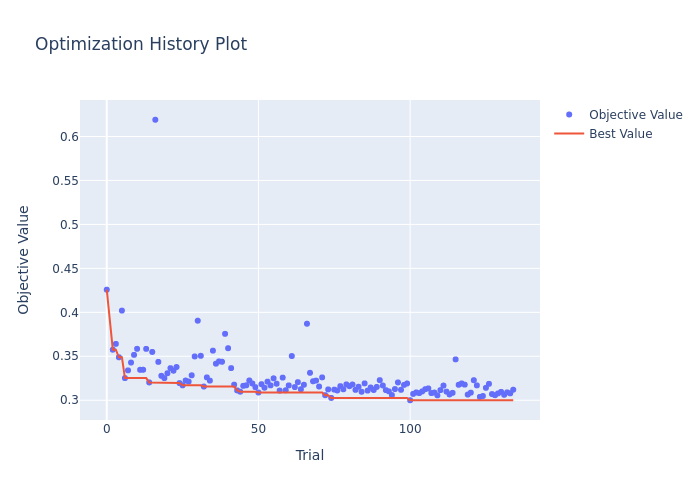

In [15]:
plot_optimization_history(study)

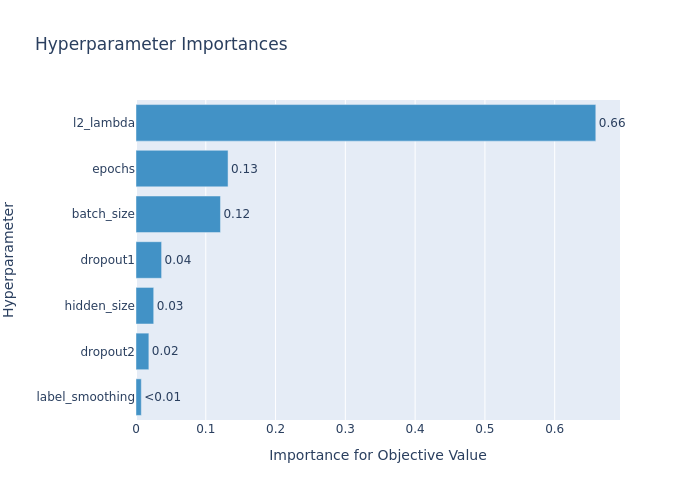

In [16]:
plot_param_importances(study)

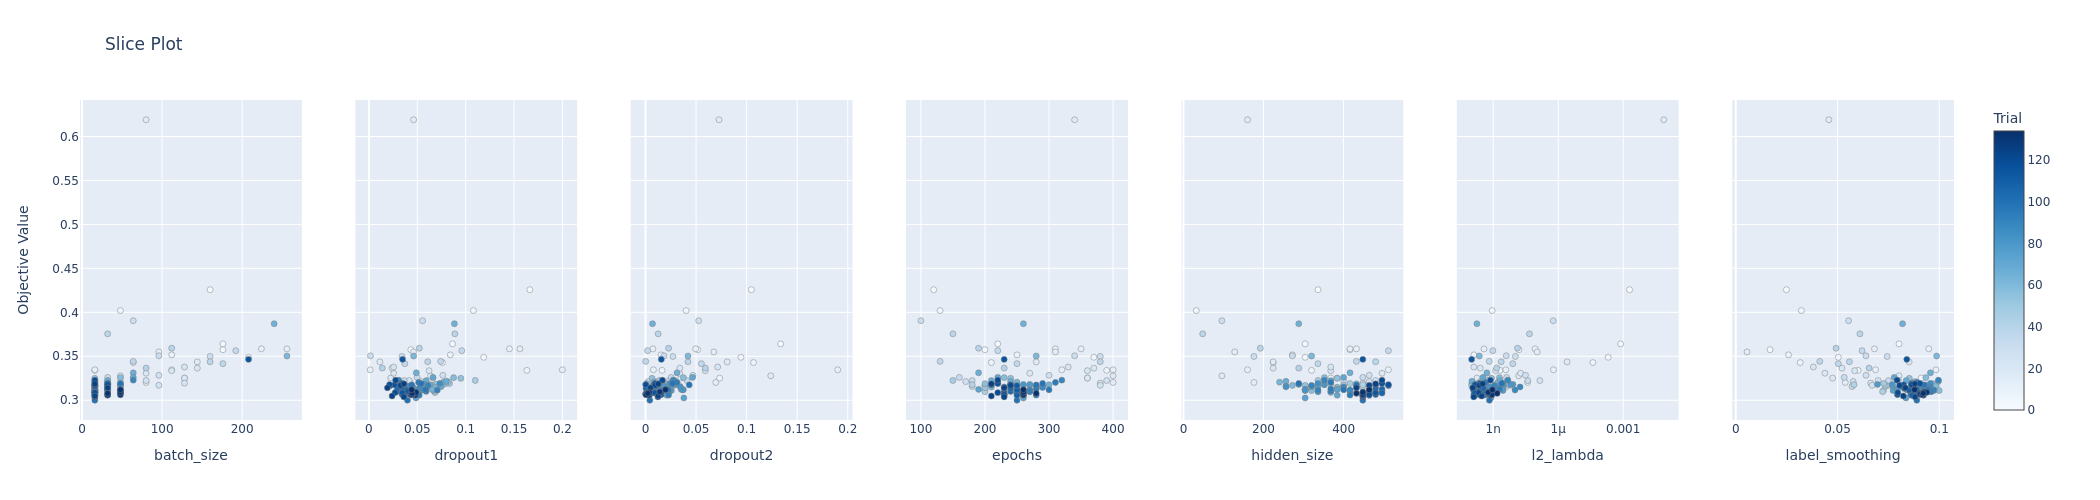

In [17]:
plot_slice(study)

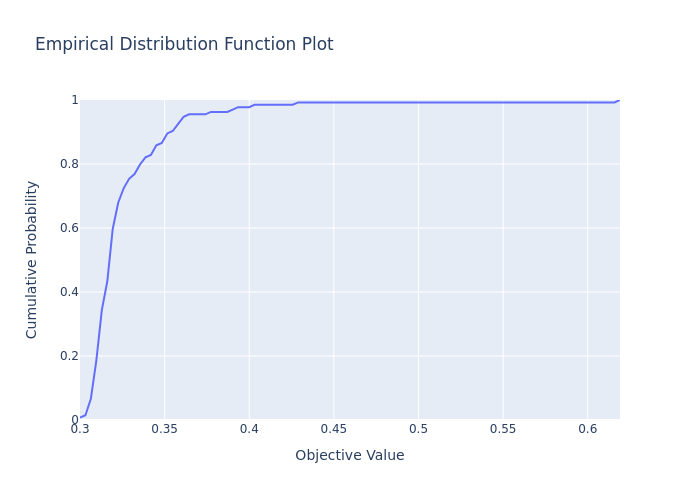

In [18]:
plot_edf(study)

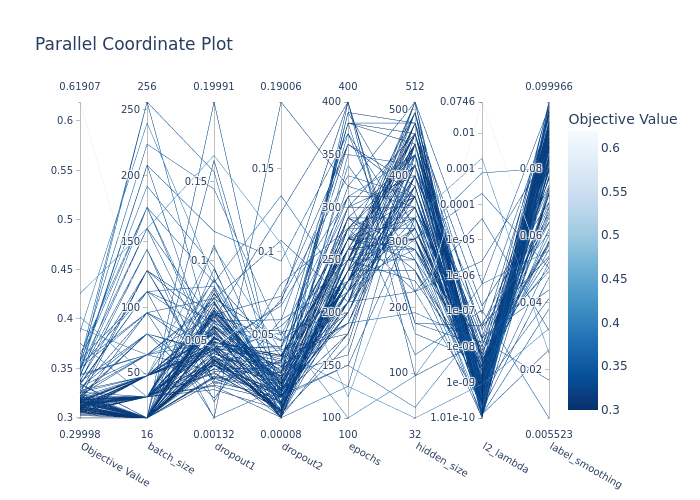

In [19]:
plot_parallel_coordinate(study)

In [20]:
best_params = dict(study.best_params)
best_params

{'batch_size': 16,
 'dropout1': 0.03982678862783072,
 'dropout2': 0.004262334659007105,
 'epochs': 250,
 'hidden_size': 448,
 'l2_lambda': 6.67436447730217e-10,
 'label_smoothing': 0.08898495026155208}

***